
# Inertia as a Form of Model Compression in Convolutional Neural Networks


> *In submission for Deep Learning Project, Spring 2025*

**Labiba Shahab**

**Ahmed Wali**


> *What you usually achieve with a standard convolution, you can accomplish efficiently using a smaller convolution + peripheral inertia mechanism (inertial filter)*
~ Group 39


## In a Gist:

Standard dxd convolution layers involve d^2 learnable parameters and d^2 computations per convolution operation. In this project, we propose an inertial convolution mechanism that dynamically decides whether a detailed convolution is necessary. The goal is to reduce both computations and learnable parameters while maintaining performance on vision tasks like MNIST classification.

Instead of learning a full dxd kernel, we use a (d-k)x(d-k) core filter to convolve a central patch. The surrounding d^2-(d-k)^2 pixels act as an inertial periphery—evaluating local divergence or “friction.” If the divergence is high, we re-apply the core filter across the full dxd region in another convolution and stack the outputs. If low, we skip detailed computation.

In the best case, we perform just d-k computation with d-k learnable parameters.
In the worst case, we perform up to d computations, but still only learn d-k parameters, hence effectively pruning the model with estimation compression.

## Background

There has been extensive research in reducing neural network complexity:

Dynamic convolutions and skip-convolutions conditionally skip expensive operations. This project is inspired from [Dynamic Sparse Convolutions](https://arxiv.org/pdf/2102.04906), [Skip Convolutions](https://openaccess.thecvf.com/content/CVPR2021/papers/Habibian_Skip-Convolutions_for_Efficient_Video_Processing_CVPR_2021_paper.pdf), and [Fractional Skipping](https://arxiv.org/abs/2001.00705)

Pruning, quantization, and knowledge distillation reduce parameters, memory, or model depth.

Our approach is inspired by these ideas but focuses on parameter reuse and friction-aware skipping, offering a novel trade-off between learning capacity and computational efficiency.

#### Novelty

Inspired from computational optimization, our project proposes a similar mechanism to do model compression by estimation.

## Baseline Models

#### MNIST 
The baseline LeNet-5 architecture used in our experiments is a direct adaptation of the official PyTorch MNIST example. We preserved all hyperparameters, architecture layers, dropout rates, optimizer, scheduler, and dataset preprocessing to ensure fair and accurate benchmarking against our proposed compressed models.

Reproducibility + Imports

In [1]:
!pip install ahdilaw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
from ahdilaw import inertial
import matplotlib.pyplot as plt

Seeds and CuDNN configs for deterministic results on a GPU

In [3]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load MNIST Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 460kB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.95MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Evaluation Function

In [5]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = correct / len(test_loader.dataset)
    print(f"Accuracy: {accuracy:.10f}")
    return accuracy

LeNet Inertial As a Package

LeNet 3x3 Model
* Adapted from [PyTorch MNIST Example](https://github.com/pytorch/examples/blob/main/mnist/main.py) to use 3x3 kernels, produced as an example in the PyTorch example series on GitHub.

In [6]:
#@adapted from https://github.com/pytorch/examples/blob/main/mnist/main.py 
class LeNet3x3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

LeNet 1x1 Model
* Adapted from the above example implementation to use 1x1 kernels instead of the original 3x3 kernels. This model is used to compare the performance of the 1x1 kernel with the original 3x3 kernel in the LeNet architecture, and with the proposed inertial filter model in future.

In [7]:
class LeNet1x1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 1, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
class LeNetSP(nn.Module):
    """LeNet with SPConv2d (CPU/GPU compatible)"""
    def __init__(self):
        super().__init__()
        self.conv1 = inertial.special.SPConv2d(1, 32, kernel_size=3, stride=1)
        self.conv2 = inertial.special.SPConv2d(32, 64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Training Function

In [9]:
def train_model(model, name):
    model = model.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    for epoch in range(15):
        model.train()
        for batch_idx, (data, target) in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        scheduler.step()

    print(f"\n{name} Results:")
    acc = test(model, device, test_loader)
    return acc

So Let's Evaluate MNIST on the Baseline


Training LeNet 3x3


Training LeNet 3x3:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy: 0.9839000000


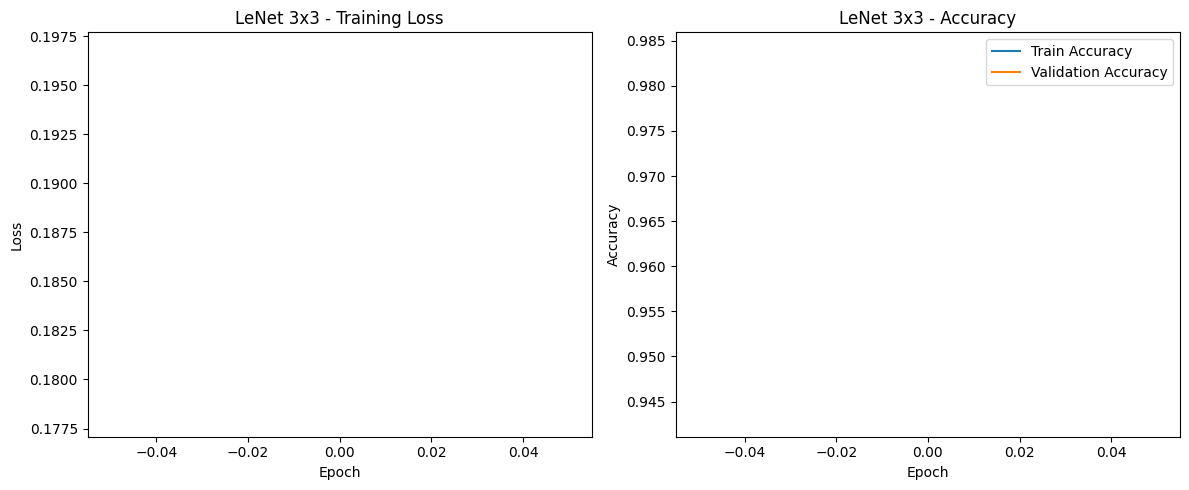

Training LeNet 3x3:   7%|▋         | 1/15 [00:15<03:32, 15.20s/it]

Accuracy: 0.9871000000


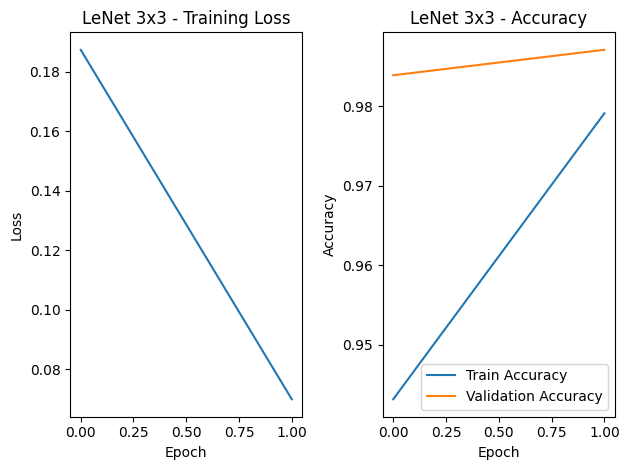

Training LeNet 3x3:  13%|█▎        | 2/15 [00:30<03:17, 15.19s/it]

Accuracy: 0.9894000000


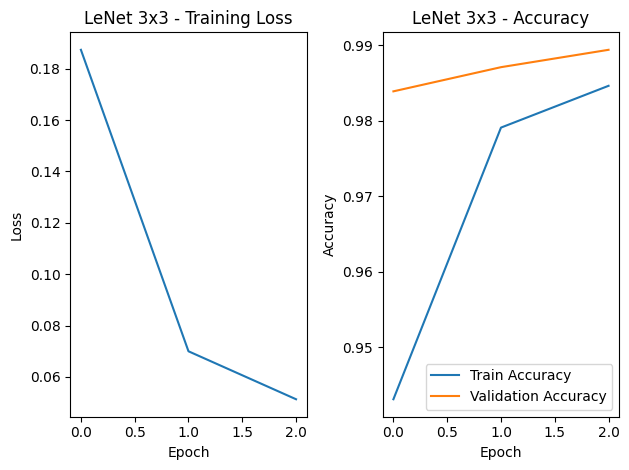

Training LeNet 3x3:  20%|██        | 3/15 [00:45<03:01, 15.12s/it]

Accuracy: 0.9901000000


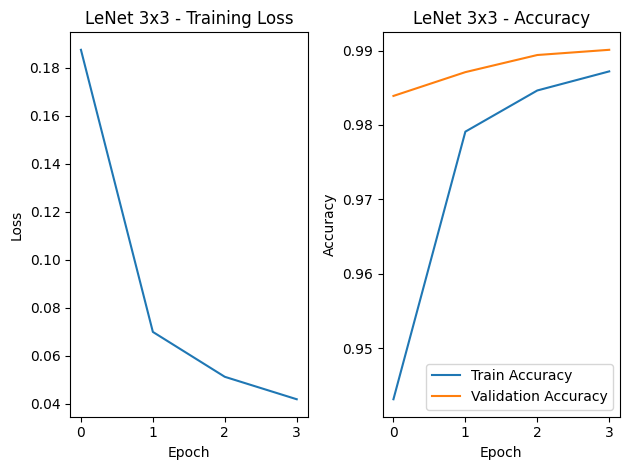

Training LeNet 3x3:  27%|██▋       | 4/15 [01:00<02:45, 15.09s/it]

Accuracy: 0.9911000000


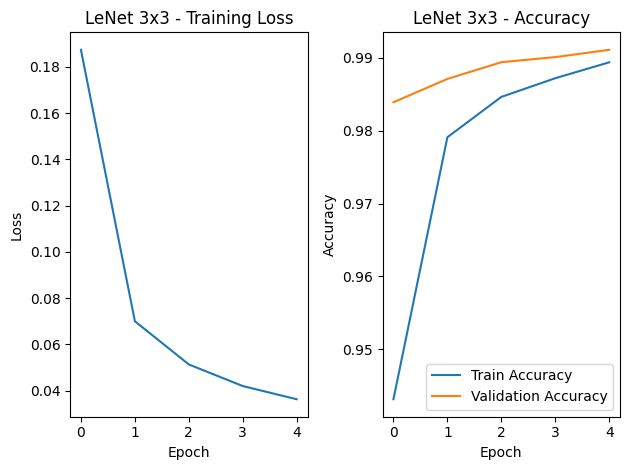

Training LeNet 3x3:  33%|███▎      | 5/15 [01:15<02:30, 15.08s/it]

Accuracy: 0.9908000000


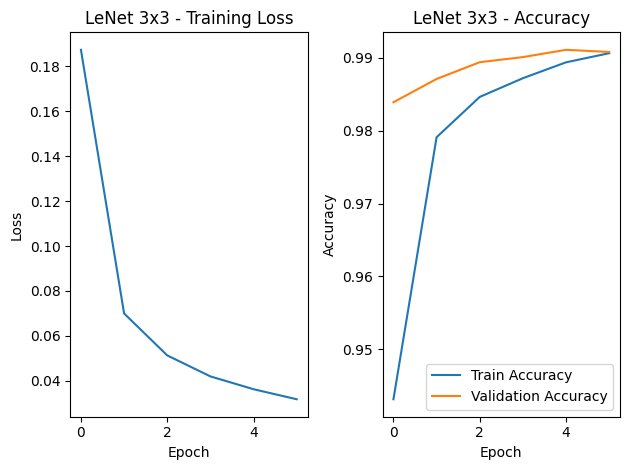

Training LeNet 3x3:  40%|████      | 6/15 [01:30<02:15, 15.11s/it]

Accuracy: 0.9915000000


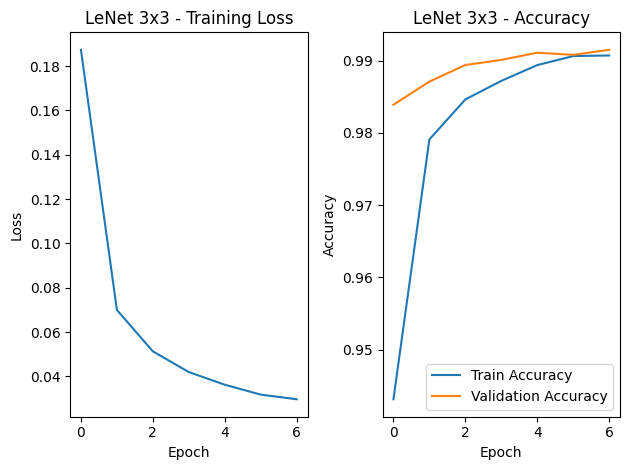

Training LeNet 3x3:  47%|████▋     | 7/15 [01:45<02:00, 15.10s/it]

Accuracy: 0.9912000000


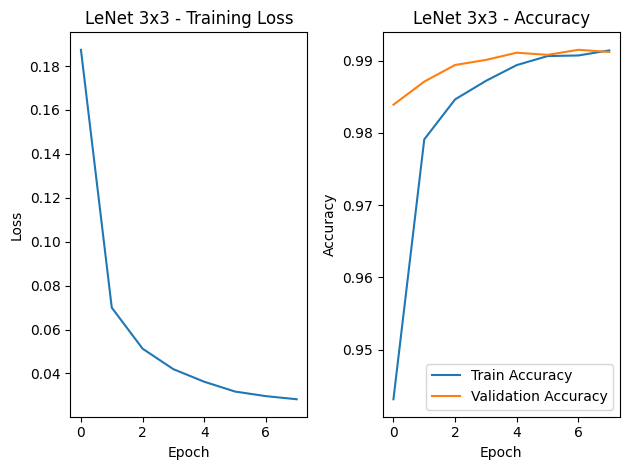

Training LeNet 3x3:  53%|█████▎    | 8/15 [02:00<01:45, 15.09s/it]

Accuracy: 0.9919000000


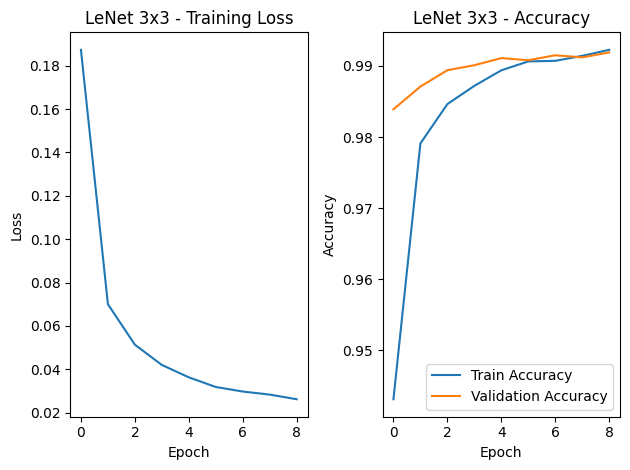

Training LeNet 3x3:  60%|██████    | 9/15 [02:16<01:30, 15.13s/it]

Accuracy: 0.9916000000


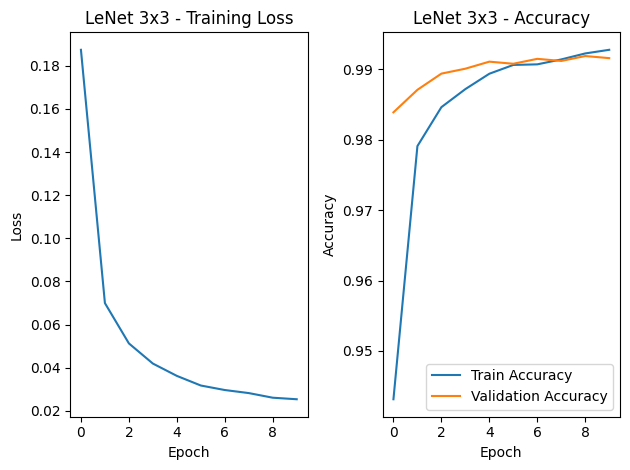

Training LeNet 3x3:  67%|██████▋   | 10/15 [02:31<01:15, 15.07s/it]

Accuracy: 0.9913000000


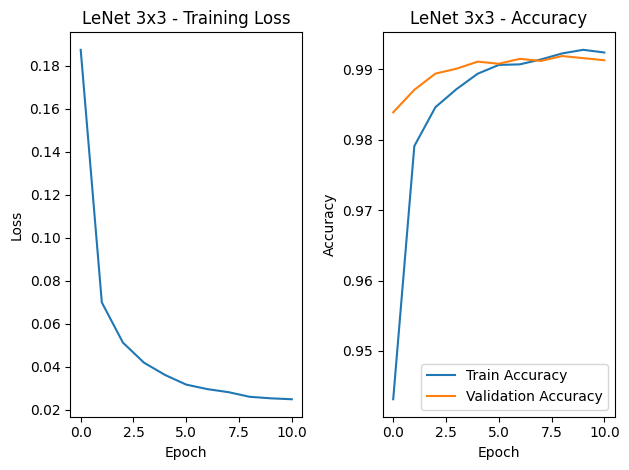

Training LeNet 3x3:  73%|███████▎  | 11/15 [02:46<01:00, 15.12s/it]

Accuracy: 0.9914000000


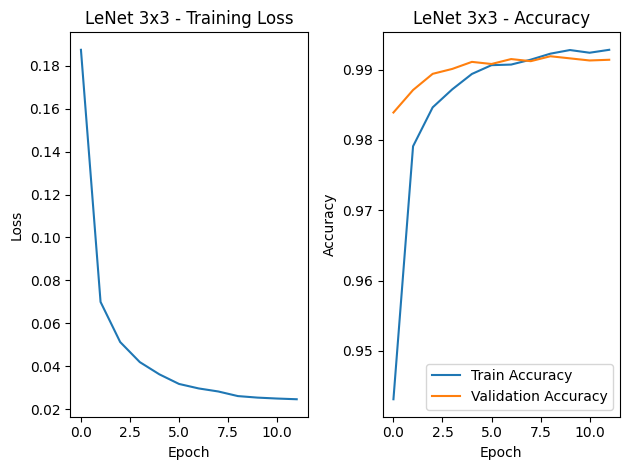

Training LeNet 3x3:  80%|████████  | 12/15 [03:01<00:45, 15.11s/it]

Accuracy: 0.9914000000


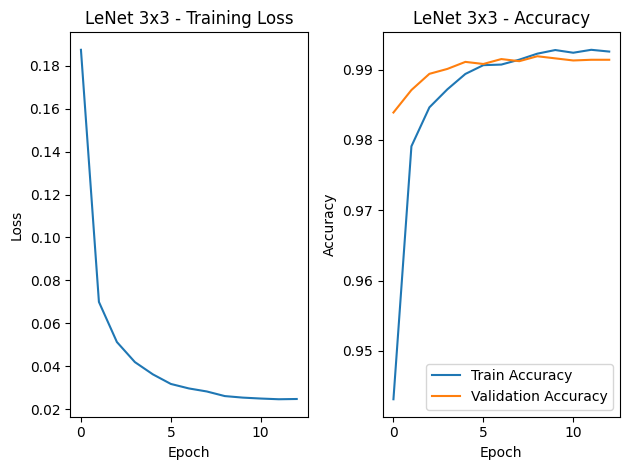

Training LeNet 3x3:  87%|████████▋ | 13/15 [03:16<00:30, 15.18s/it]

Accuracy: 0.9916000000


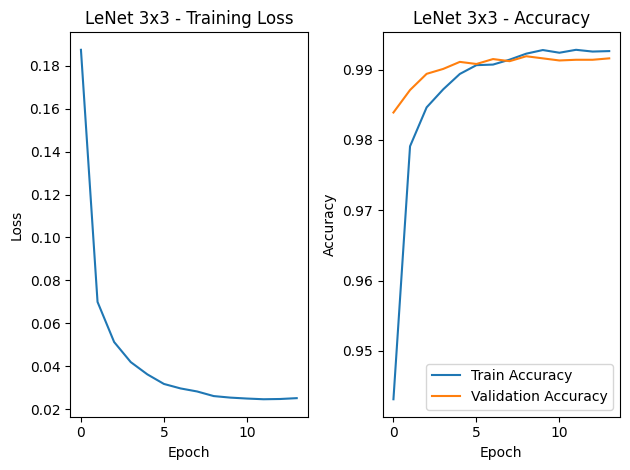

Training LeNet 3x3:  93%|█████████▎| 14/15 [03:32<00:15, 15.23s/it]

Accuracy: 0.9914000000


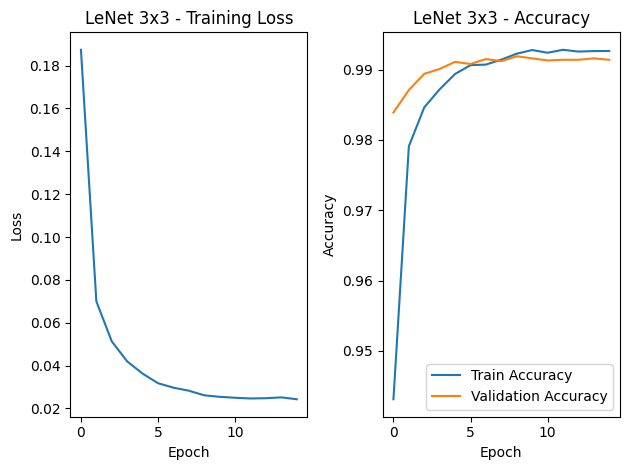

Training LeNet 3x3: 100%|██████████| 15/15 [03:47<00:00, 15.17s/it]
/tmp/ipykernel_31/2317526745.py:73: UserWarning: mods argument is not needed anymore, you can stop passing it
  flop_counter = FlopCounterMode(model)


Module                   FLOP    % Total
--------------------  -------  ---------
LeNet3x3              23.985M    100.00%
 - aten.convolution   21.623M     90.15%
 - aten.addmm          2.362M      9.85%
 LeNet3x3.conv1        0.389M      1.62%
  - aten.convolution   0.389M      1.62%
 LeNet3x3.conv2       21.234M     88.53%
  - aten.convolution  21.234M     88.53%
 LeNet3x3.fc1          2.359M      9.84%
  - aten.addmm         2.359M      9.84%
 LeNet3x3.fc2          0.003M      0.01%
  - aten.addmm         0.003M      0.01%

LeNet 3x3 Summary:
Final Validation Accuracy: 0.9914
Total Parameters: 1,199,882
Total FLOPs: 23,984,896

Training LeNet 1x1


Training LeNet 1x1:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy: 0.9248000000


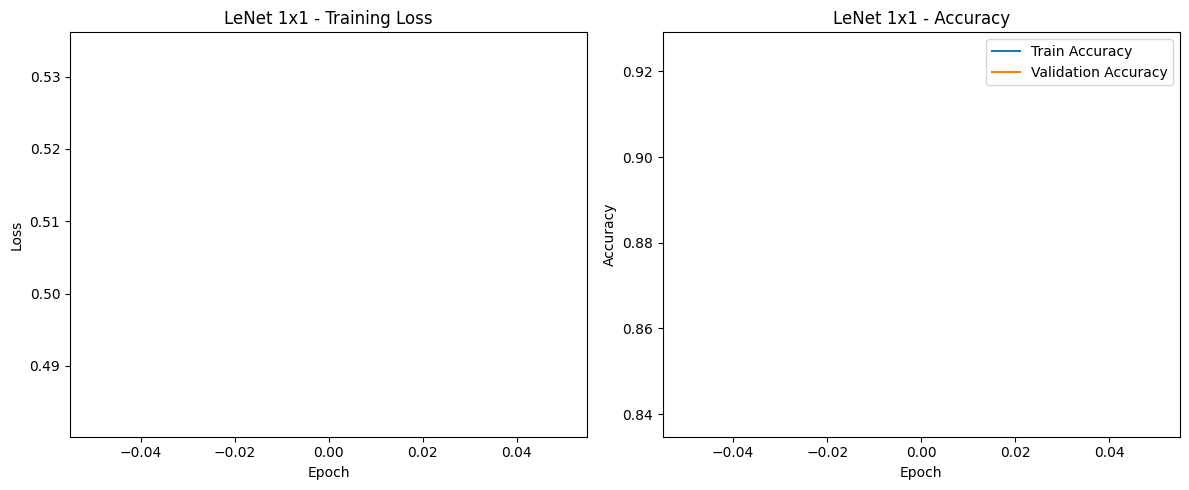

Training LeNet 1x1:   7%|▋         | 1/15 [00:16<03:56, 16.89s/it]

Accuracy: 0.9516000000


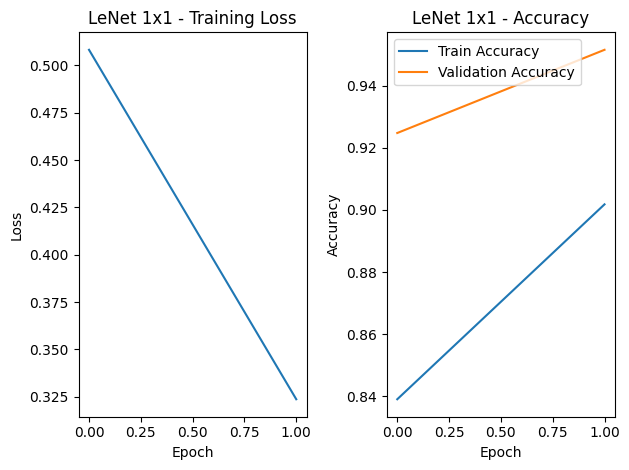

Training LeNet 1x1:  13%|█▎        | 2/15 [00:34<03:41, 17.06s/it]

Accuracy: 0.9545000000


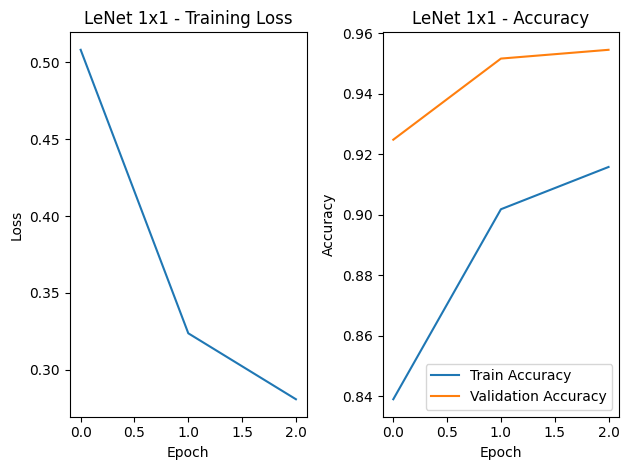

Training LeNet 1x1:  20%|██        | 3/15 [00:50<03:23, 16.95s/it]

Accuracy: 0.9602000000


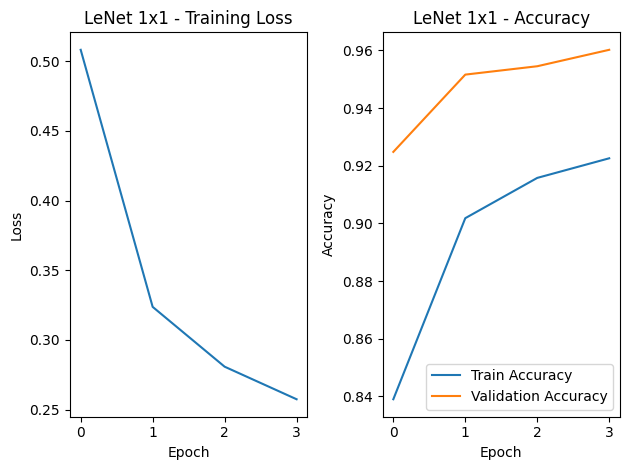

Training LeNet 1x1:  27%|██▋       | 4/15 [01:07<03:07, 17.01s/it]

Accuracy: 0.9607000000


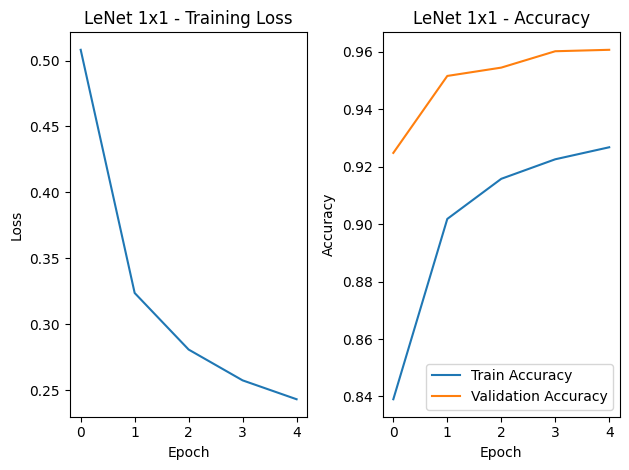

Training LeNet 1x1:  33%|███▎      | 5/15 [01:24<02:49, 16.99s/it]

Accuracy: 0.9635000000


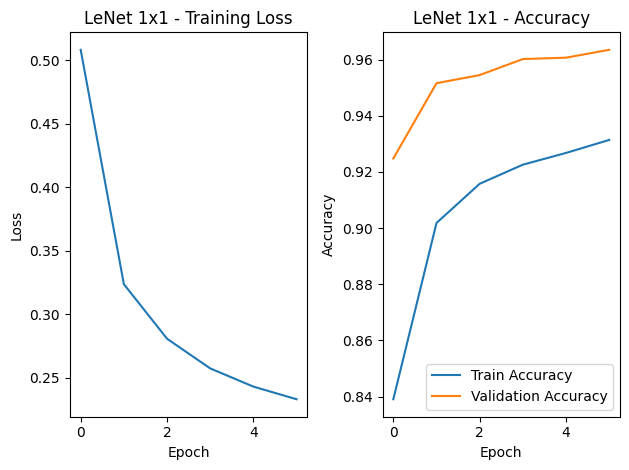

Training LeNet 1x1:  40%|████      | 6/15 [01:41<02:32, 16.94s/it]

Accuracy: 0.9628000000


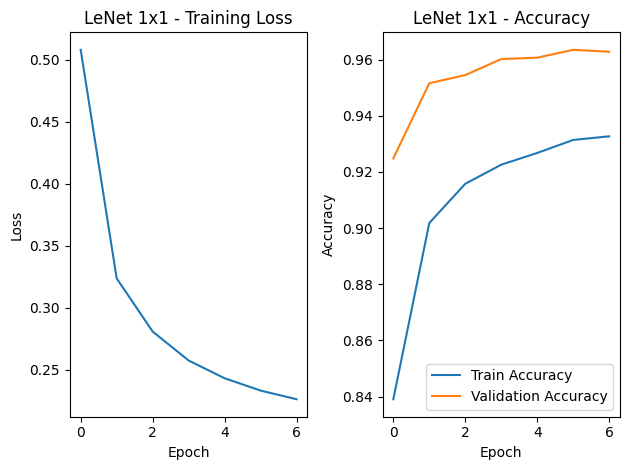

Training LeNet 1x1:  47%|████▋     | 7/15 [01:58<02:15, 16.91s/it]

Accuracy: 0.9643000000


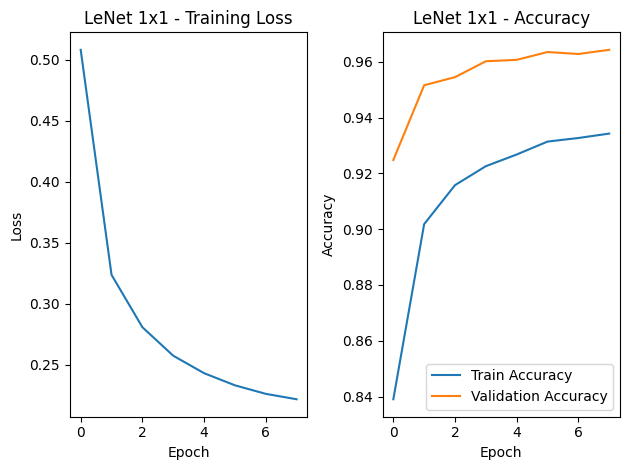

Training LeNet 1x1:  53%|█████▎    | 8/15 [02:15<01:57, 16.86s/it]

Accuracy: 0.9639000000


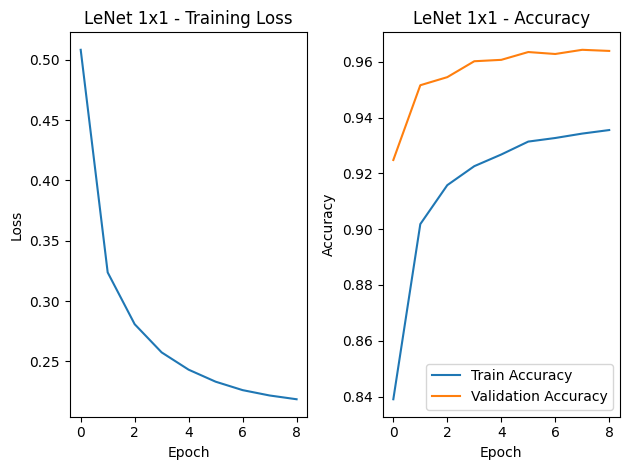

Training LeNet 1x1:  60%|██████    | 9/15 [02:32<01:41, 16.85s/it]

Accuracy: 0.9647000000


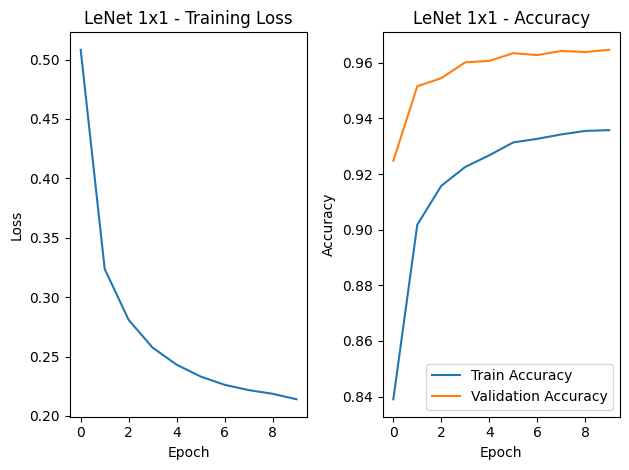

Training LeNet 1x1:  67%|██████▋   | 10/15 [02:49<01:24, 16.85s/it]

Accuracy: 0.9639000000


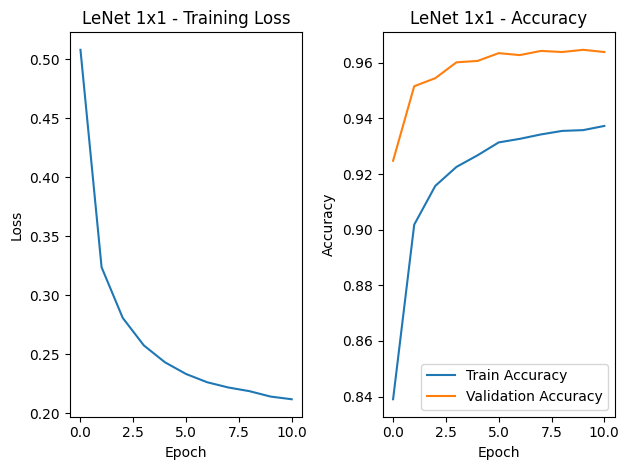

Training LeNet 1x1:  73%|███████▎  | 11/15 [03:05<01:07, 16.85s/it]

Accuracy: 0.9639000000


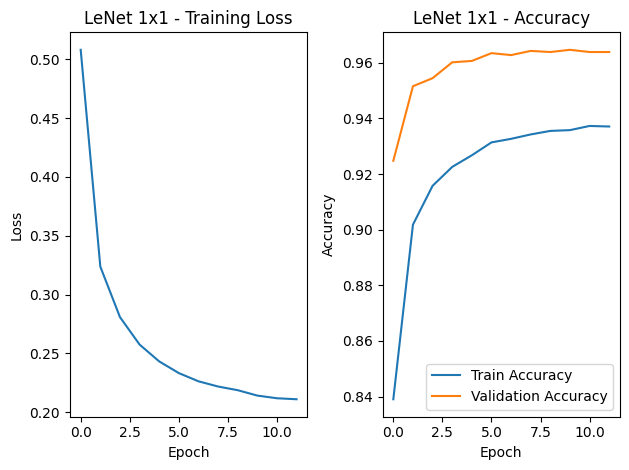

Training LeNet 1x1:  80%|████████  | 12/15 [03:22<00:50, 16.82s/it]

Accuracy: 0.9650000000


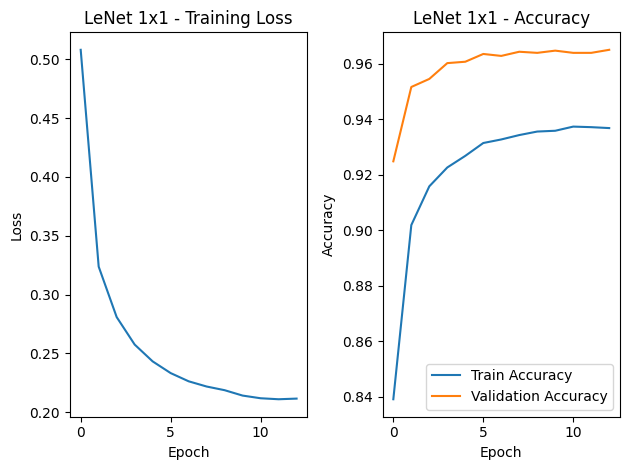

Training LeNet 1x1:  87%|████████▋ | 13/15 [03:39<00:33, 16.85s/it]

Accuracy: 0.9646000000


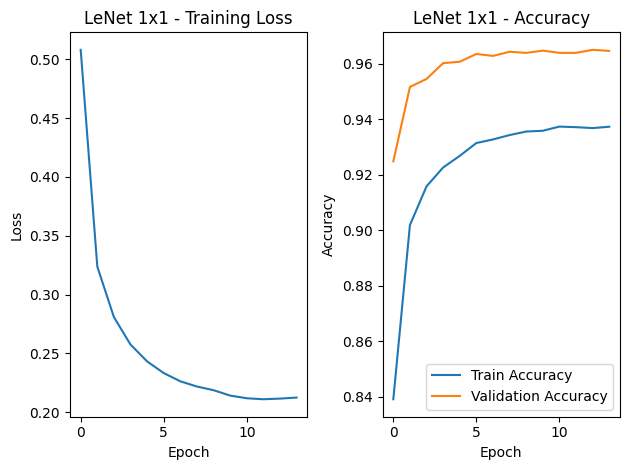

Training LeNet 1x1:  93%|█████████▎| 14/15 [03:56<00:16, 16.85s/it]

Accuracy: 0.9647000000


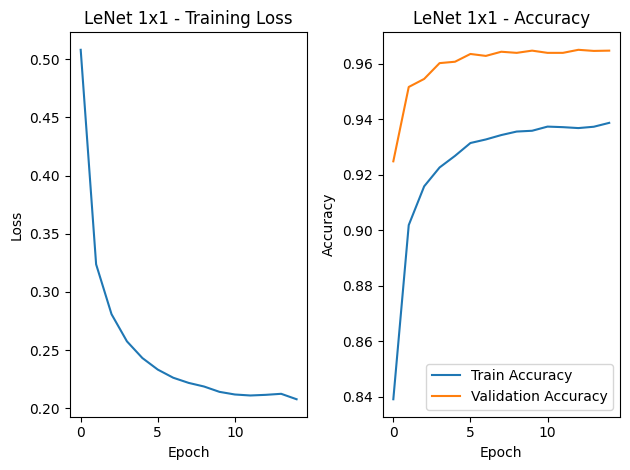

Training LeNet 1x1: 100%|██████████| 15/15 [04:13<00:00, 16.90s/it]


Module                     FLOP    % Total
--------------------  ---------  ---------
LeNet1x1              6475.264K    100.00%
 - aten.convolution   3261.440K     50.37%
 - aten.addmm         3213.824K     49.63%
 LeNet1x1.conv1         50.176K      0.77%
  - aten.convolution    50.176K      0.77%
 LeNet1x1.conv2       3211.264K     49.59%
  - aten.convolution  3211.264K     49.59%
 LeNet1x1.fc1         3211.264K     49.59%
  - aten.addmm        3211.264K     49.59%
 LeNet1x1.fc2            2.560K      0.04%
  - aten.addmm           2.560K      0.04%

LeNet 1x1 Summary:
Final Validation Accuracy: 0.9647
Total Parameters: 1,609,226
Total FLOPs: 6,475,264

Training LeNet SP


Training LeNet SP:   0%|          | 0/15 [00:00<?, ?it/s]

Accuracy: 0.9470000000


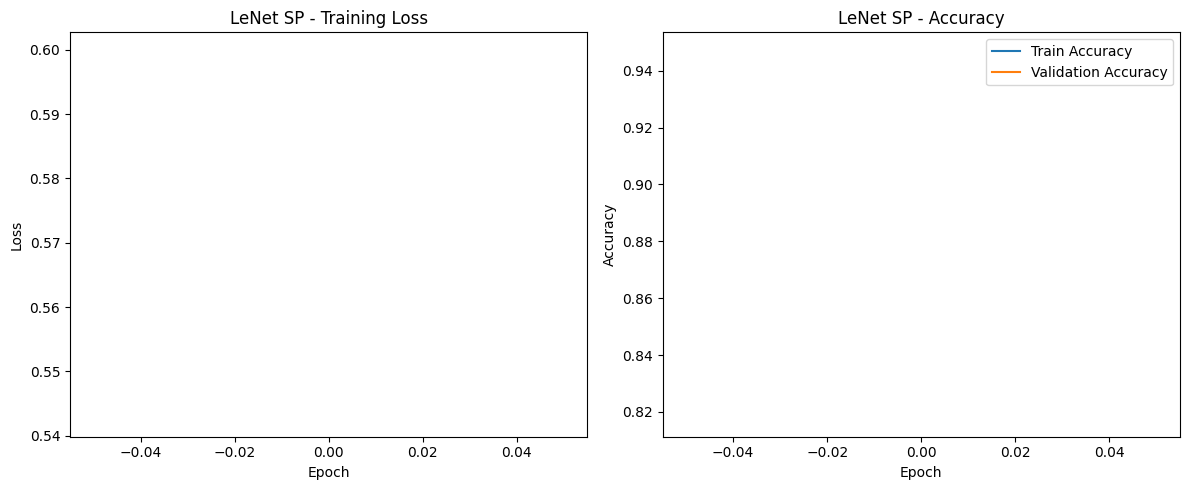

Training LeNet SP:   7%|▋         | 1/15 [00:29<06:54, 29.62s/it]

Accuracy: 0.9604000000


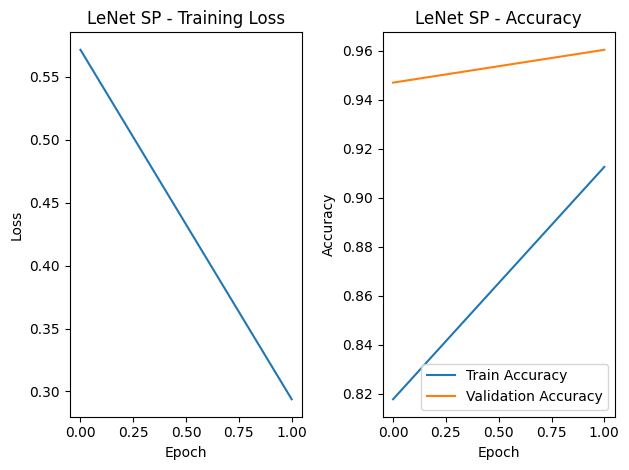

Training LeNet SP:  13%|█▎        | 2/15 [00:59<06:23, 29.49s/it]

Accuracy: 0.9662000000


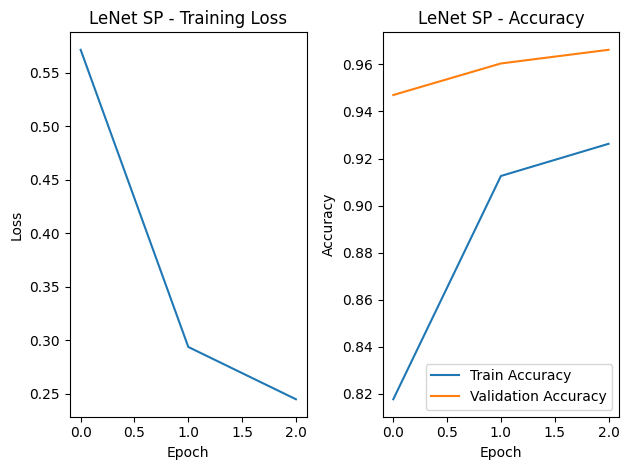

Training LeNet SP:  20%|██        | 3/15 [01:27<05:51, 29.26s/it]

Accuracy: 0.9658000000


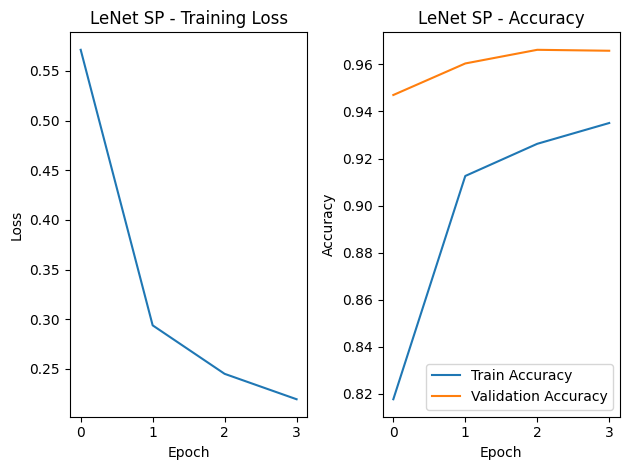

Training LeNet SP:  27%|██▋       | 4/15 [01:57<05:20, 29.17s/it]

Accuracy: 0.9707000000


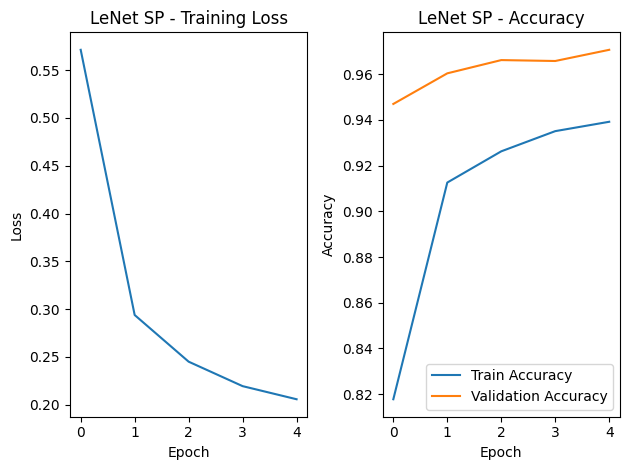

Training LeNet SP:  33%|███▎      | 5/15 [02:26<04:51, 29.15s/it]

Accuracy: 0.9684000000


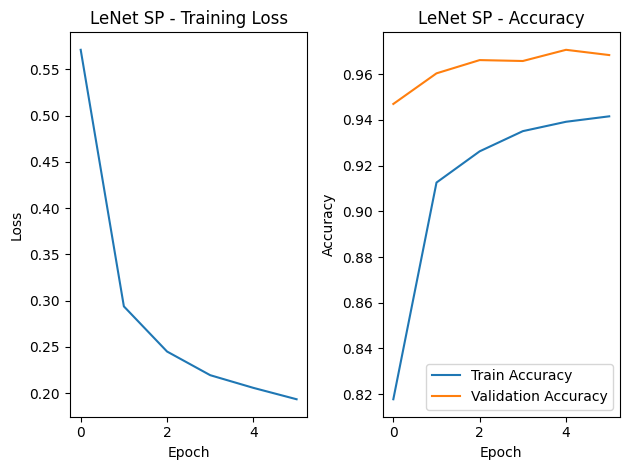

Training LeNet SP:  40%|████      | 6/15 [02:55<04:22, 29.14s/it]

Accuracy: 0.9715000000


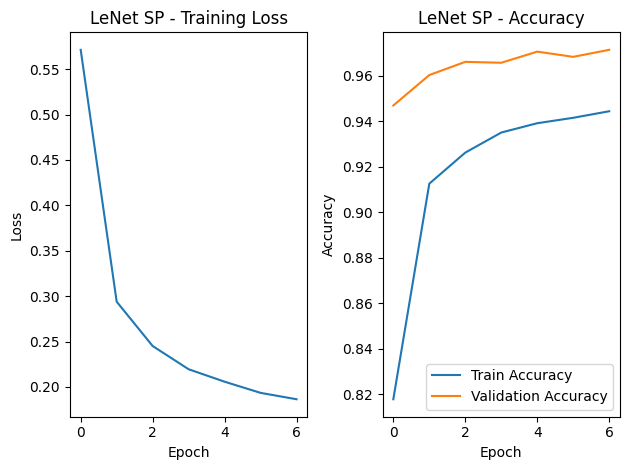

Training LeNet SP:  47%|████▋     | 7/15 [03:24<03:53, 29.14s/it]

Accuracy: 0.9717000000


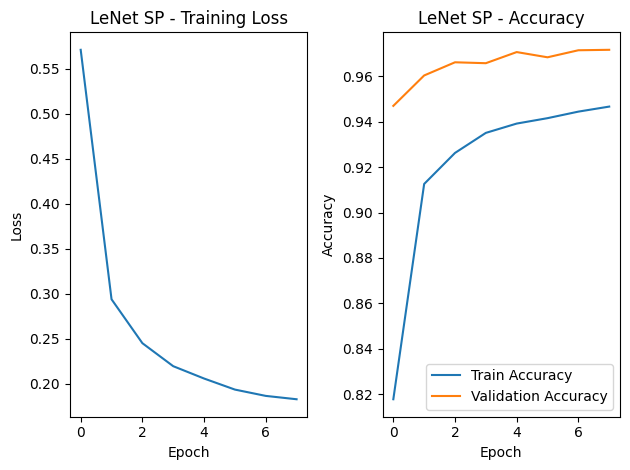

Training LeNet SP:  53%|█████▎    | 8/15 [03:53<03:24, 29.15s/it]

Accuracy: 0.9713000000


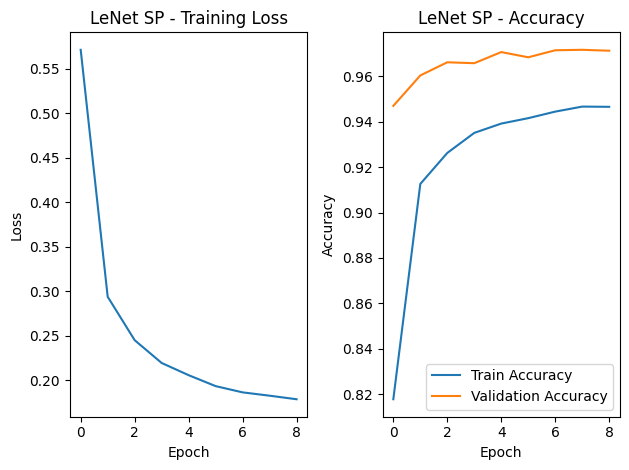

Training LeNet SP:  60%|██████    | 9/15 [04:23<02:55, 29.26s/it]

Accuracy: 0.9735000000


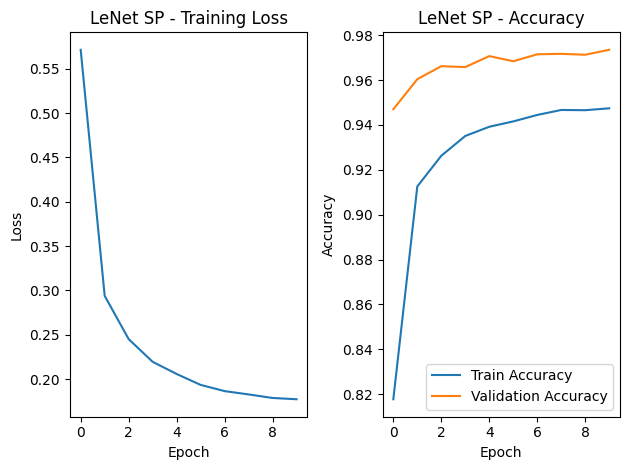

Training LeNet SP:  67%|██████▋   | 10/15 [04:52<02:26, 29.37s/it]

Accuracy: 0.9725000000


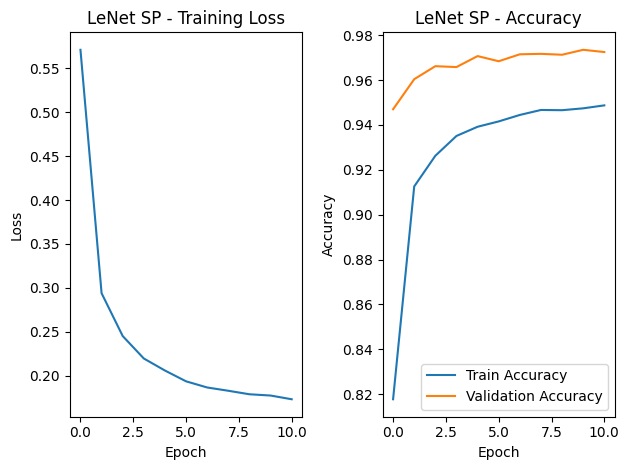

Training LeNet SP:  73%|███████▎  | 11/15 [05:22<01:57, 29.45s/it]

Accuracy: 0.9729000000


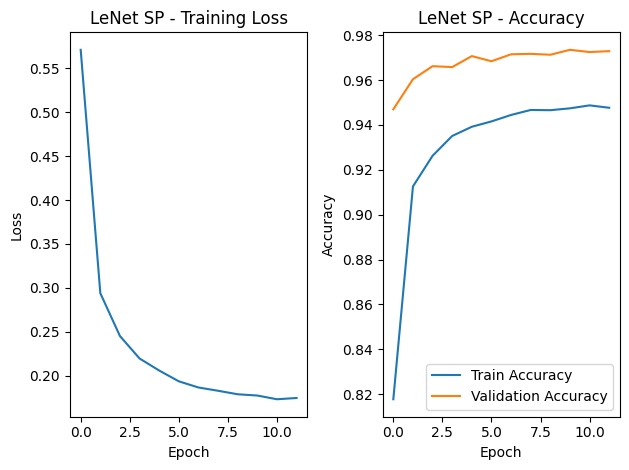

Training LeNet SP:  80%|████████  | 12/15 [05:51<01:28, 29.38s/it]

Accuracy: 0.9734000000


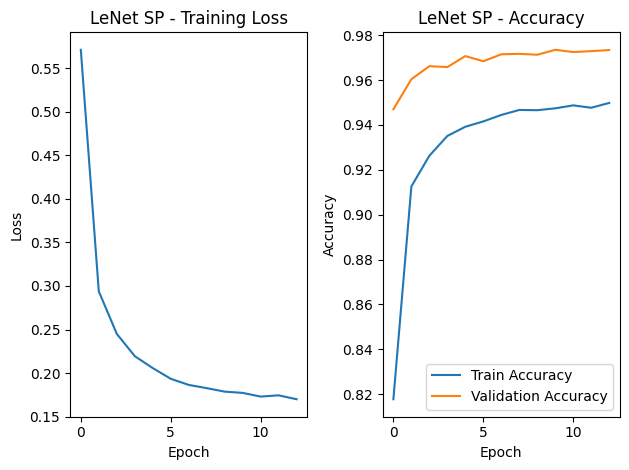

Training LeNet SP:  87%|████████▋ | 13/15 [06:20<00:58, 29.28s/it]

Accuracy: 0.9732000000


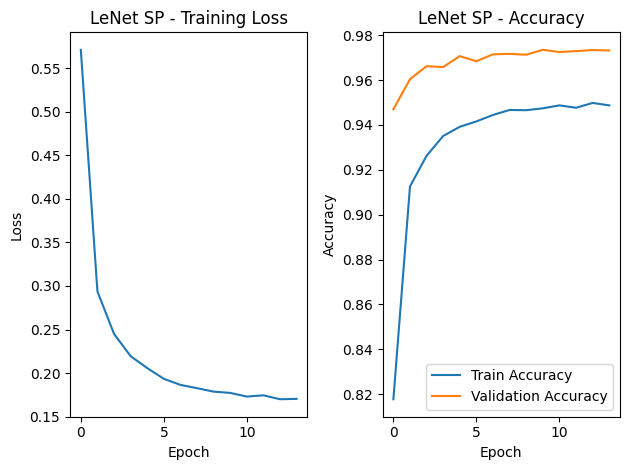

Training LeNet SP:  93%|█████████▎| 14/15 [06:49<00:29, 29.23s/it]

Accuracy: 0.9738000000


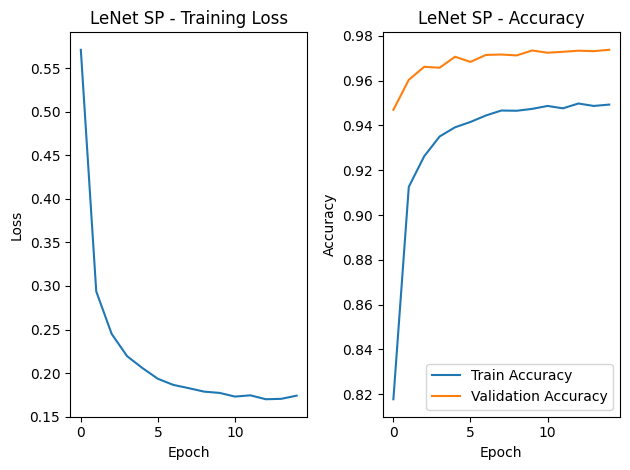

Training LeNet SP: 100%|██████████| 15/15 [07:18<00:00, 29.26s/it]


Module               FLOP    % Total
--------------  ---------  ---------
LeNetSP         4764.416K    100.00%
 - aten.mm      2402.560K     50.43%
 - aten.addmm   2361.856K     49.57%
 LeNetSP.conv1    43.264K      0.91%
  - aten.mm       43.264K      0.91%
 LeNetSP.conv2  2359.296K     49.52%
  - aten.mm     2359.296K     49.52%
 LeNetSP.fc1    2359.296K     49.52%
  - aten.addmm  2359.296K     49.52%
 LeNetSP.fc2       2.560K      0.05%
  - aten.addmm     2.560K      0.05%

LeNet SP Summary:
Final Validation Accuracy: 0.9738
Total Parameters: 1,183,166
Total FLOPs: 4,764,416


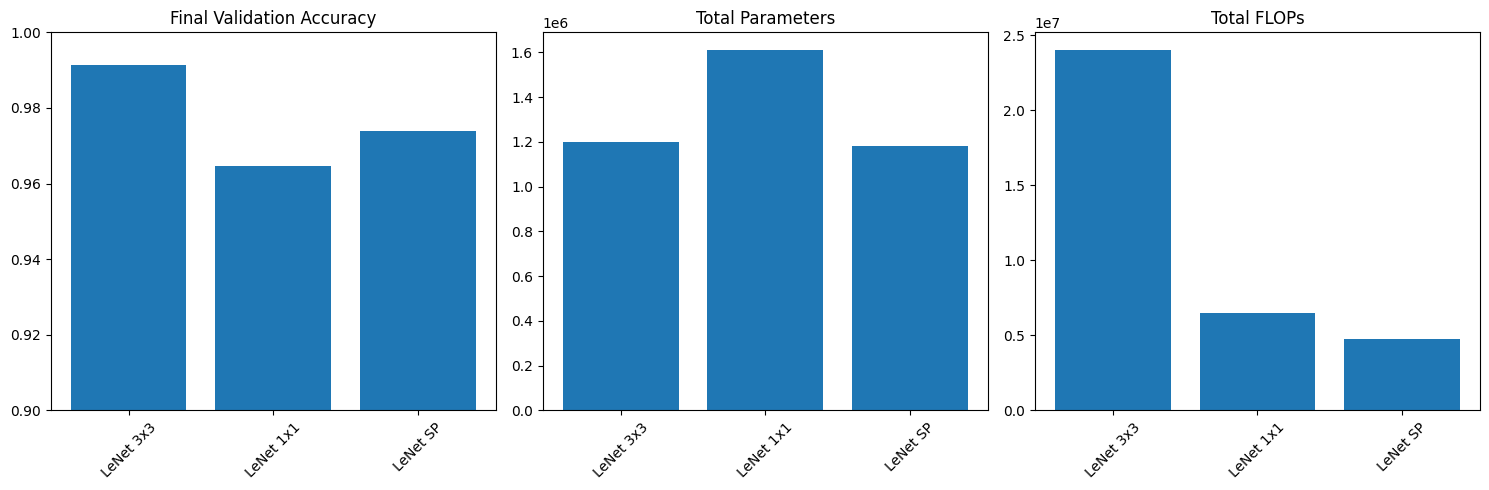


Model Comparison:
Model           |   Accuracy |          Params |           FLOPs
------------------------------------------------------------
LeNet 3x3       |     0.9914 |       1,199,882 |      23,984,896
LeNet 1x1       |     0.9647 |       1,609,226 |       6,475,264
LeNet SP        |     0.9738 |       1,183,166 |       4,764,416


In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.flop_counter import FlopCounterMode

def train_model(model, name):
    model = model.to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=1.0)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
    
    # Initialize tracking
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Create figure
    plt.figure(figsize=(12, 5))
    
    for epoch in tqdm(range(15), desc=f"Training {name}"):
        model.train()
        epoch_loss = 0
        correct = 0
        
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Store metrics
        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        val_acc = test(model, device, test_loader)
        val_accuracies.append(val_acc)
        
        scheduler.step()
        
        # Update plot
        plt.clf()
        
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.title(f'{name} - Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label='Train Accuracy')
        plt.plot(val_accuracies, label='Validation Accuracy')
        plt.title(f'{name} - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.pause(0.1)  # Update plot
    
    plt.show()
    
    # Calculate model stats
    with torch.no_grad():
        flop_counter = FlopCounterMode(model)
        with flop_counter:
            model(torch.randn(1, 1, 28, 28).to(device))
        total_flops = sum(flop_counter.get_flop_counts()['Global'].values())
        total_params = sum(p.numel() for p in model.parameters())
    
    print(f"\n{name} Summary:")
    print(f"Final Validation Accuracy: {val_acc:.4f}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Total FLOPs: {total_flops:,}")
    
    return {
        'accuracy': val_acc,
        'params': total_params,
        'flops': total_flops,
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }

# Original baselines
model_3x3 = LeNet3x3()
model_1x1 = LeNet1x1()

# Inertial variants
models = {
    "LeNet 3x3": model_3x3,
    "LeNet 1x1": model_1x1,
    "LeNet SP": LeNetSP(),
}

# Train and evaluate all models
results = {}
for name, model in models.items():
    try:
        print(f"\n{'='*40}\nTraining {name}\n{'='*40}")
        results[name] = train_model(model, name)
    except Exception as e:
        print(f"Failed to train {name}: {e}")

# Final comparison plot
plt.figure(figsize=(15, 5))

# Accuracy comparison
plt.subplot(1, 3, 1)
plt.bar(results.keys(), [r['accuracy'] for r in results.values()])
plt.title('Final Validation Accuracy')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)

# Parameter comparison
plt.subplot(1, 3, 2)
plt.bar(results.keys(), [r['params'] for r in results.values()])
plt.title('Total Parameters')
plt.xticks(rotation=45)

# FLOPs comparison
plt.subplot(1, 3, 3)
plt.bar(results.keys(), [r['flops'] for r in results.values()])
plt.title('Total FLOPs')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print final table
print("\nModel Comparison:")
print(f"{'Model':<15} | {'Accuracy':>10} | {'Params':>15} | {'FLOPs':>15}")
print("-"*60)
for name, res in results.items():
    print(f"{name:<15} | {res['accuracy']:>10.4f} | {res['params']:>15,} | {res['flops']:>15,}")

#### Note:

This dataset serves as a good starting point due to its simplicity and low variance. We will use this dataset as the initial starting point for our analysis. We will adapt the standard pytorch LeNet-5 implementation with 2 convolutional layers in 3x3 filters. We will then train a similar model with the only alteration made such that the two convolutional layers use 1x1 core filters + 1 pixel periphery, and we would compare the results. If the results are comparable, we would have effectively reduced the number of learnable parameters and potentially the computational bulk due to the smaller kernel size.

**What do we expect?**

Since the MNIST dataset is a grascale dataset, we anticipate low divergence or friction across patches in images, hence we anticipate improved performance due to the use of inertial filters.